<a href="https://colab.research.google.com/github/TrevorSeestedt/LLM-comparison/blob/main/LLM_Comparison_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LLMs for Classification on IMDB Movie Review Dataset

Downloading the IMDB Dataset of 50,000 Movie Reviews

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


Libraries that are utilized throughout the project.

In [2]:
# Libraries that will be used
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, get_linear_schedule_with_warmup
# Instead of importing from transformers.optimization, import from torch.optim
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Overview of Dataset

In [3]:
# Load the dataset
df = pd.read_csv(path + '/IMDB Dataset.csv')

# Print first 5 rows
print(f"\nFirst 5 rows:\n {df.head()}")

# Check for missing values
print(f"\nMissing values:\n {df.isnull().sum()}")

# Check shape of the dataset
print(f"\nDataset contains: \n {df.shape[0]} rows and {df.shape[1]} columns")

# Columns within dataset
print("Columns in the dataset:")
print(df.columns.tolist())

# Class distribution counts
class_counts = df['sentiment'].value_counts()
print(f"\nClass distribution counts:\n {class_counts}")

# Class distribution percent
class_percentage = class_counts / df.shape[0] * 100
print(f"\nClass distribution percentage:\n {class_percentage}")


First 5 rows:
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values:
 review       0
sentiment    0
dtype: int64

Dataset contains: 
 50000 rows and 2 columns
Columns in the dataset:
['review', 'sentiment']

Class distribution counts:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Class distribution percentage:
 sentiment
positive    50.0
negative    50.0
Name: count, dtype: float64


# Data Preprocessing

To preprocess the data the are a few steps that are taken to do so. The first step that must be done is text-cleaning, this is where the raw text data is cleaned through the removal of the HTML tags and special characters that are unable to be read. This will help the input become more direct, additionally, the text is converted to lowercase to maintain the consistency and so the model's performance can be enhanced.  

In [4]:
# Data cleaning function
import re

def preprocessing_data(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply cleaning
df['cleaned_review'] = df['review'].apply(preprocessing_data)

# Encode labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Spliting the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_review'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

Here, I preprocessed the review column by utilizing the function that I created above. I also then converted the sentiment column ('positive' and 'negative') into numerical labels (0 and 1) to which I stored them in a new column called label. I then split the dataset using train_test_split with a 80-20 split meaning that 20% is using for testing and 80% is used for training. I then tokenized the newly cleaned text by utilizing the DistilBertTokenizerFast, which will convert the text into token ID's for DistilBERT. The output will be the tokenized data which includes the token IDs, thus the tokenized data will be ready for model training and evaluation.

In [5]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the training and validation data
train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=128
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=128
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Fine Tuning

In [6]:
# Create a custom dataset class
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels): # constructor of the class
        self.encodings = encodings # tokenized input data
        self.labels = labels # target variables

    def __len__(self):
        return len(self.labels) # returns total sample number within dataset

    def __getitem__(self, idx):
        # Item is a dictionary with the following keys: input_ids, attention_mask, labels
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Create dataset instances
train_dataset = IMDbDataset(train_encodings, train_labels.reset_index(drop=True)) # Instance of the IMDbDataset class is created for training data
val_dataset = IMDbDataset(val_encodings, val_labels.reset_index(drop=True))

In [7]:
# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the following code the device variable is initialized as it will determine the device that is used for the computation. The function torch.cuda.is_available() checks if a CUDA-enabled GPU is available, if it is found then it returns true if not then false. If the GPU is available then it will create a torch.device object to represent the GPU, and if not then torch.device represents the CPU. The optimizer initializes the AdamW optimizer with a learning rate of 5e-5 (0.00005) which will control the step size that the optimizer takes throughout updating the parameters of the model. Next, the dataloaders are for both training and validating the datasets, they are essential for the iterating efficiency during training. By utilizing RandomSampler, it will ensure that the training data is shuffled randomly for each epoch to help the model from overfitting to the order of the data. Additionally, the SequentialSampler ensures that the validation data is processed sequentially, allowing for consistent evaluation. The batch size shall specify the number of samples processed for each batch. The training batch size is set to 16 and the evaluation bactch size to 64. Total_steps shall calculate the total amount of training steps throughout the process, this is the number of batches in the training data loader times the number of epochs. The learning rate scheduler is made to dynamically adjust the learning rate during the training process, it will improve the convergence and performance of the process.

In [8]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the model here to make sure it's defined
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

model.to(device)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

# Total number of training steps
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

epochs = 3
train_batch_size = 16
eval_batch_size = 64

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=train_batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=eval_batch_size)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The following is the training function, this script trains and validates the machine learning learning model by utilizing PyTorch. The inputs do the following, model is the pytorch model that will be trained, the trained_dataloader is the dataloader for the training data, the val_dataloader is the dataloader for the validation data, and epochs is the number of training epochs. The function will output/return two lists, training_loss_values and validation_loss_values, both track the average training and validation losses across each epoch.

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(model, train_dataloader, val_dataloader, epochs):
    training_loss_values = [] # List to store training loss values per epoch
    validation_loss_values = [] # List to store validation loss values per epoch

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}') # Outputs to see what epoch is currently occurring
        print('-' * 10)

        # Training phase
        model.train() # Setting the model to training mode
        total_train_loss = 0 # Total training loss is initialized for the epoch

        for batch in train_dataloader:
            optimizer.zero_grad() # Clear the gradients that ocurred previously

            # Input data and labels are moved to the device (GPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss # Loss value

            total_train_loss += loss.item() # Total training loss

            loss.backward() # Backpropogating the errors
            optimizer.step() # Update the models parameters
            scheduler.step() # Adjusting the learning rate if the scheduler is utilized

        # Calculating the average training loss per epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss_values.append(avg_train_loss) # Appending the average loss to the list

        print(f'Training loss: {avg_train_loss:.4f}')

        # Validation phase
        model.eval() # Model is now set to the evaluation mode
        total_eval_loss = 0 # Initialize the total validation loss
        all_preds = [] # Storing predictions
        all_labels = [] # Store true labels

        for batch in val_dataloader:
            with torch.no_grad(): # Disabling the gradient computation
                # Moving input data and labels to the device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss # Get the loss value

                total_eval_loss += loss.item() # Total training loss

                logits = outputs.logits # Get model predictions
                preds = torch.argmax(logits, dim=1).flatten() # Get predicted class indices

                # extending the prediction and label lists for metric calculations
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate the average validation loss for the epochs
        avg_val_loss = total_eval_loss / len(val_dataloader)
        validation_loss_values.append(avg_val_loss) # Append the average loss to the list

        # Calculate evaluation metrics
        accuracy = accuracy_score(all_labels, all_preds) # Calculate the accuracy
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

        # Logging the validation metrics
        print(f'Validation loss: {avg_val_loss:.4f}')
        print(f'Validation accuracy: {accuracy:.4f}')
        print(f'Validation precision: {precision:.4f}')
        print(f'Validation recall: {recall:.4f}')
        print(f'Validation F1 score: {f1:.4f}\n')

    return training_loss_values, validation_loss_values # Return the training and validation loss values

In [10]:
# Start training and record loss values
training_loss_values, validation_loss_values = train(model, train_dataloader, val_dataloader, epochs)

Epoch 1/3
----------
Training loss: 0.3296
Validation loss: 0.2692
Validation accuracy: 0.8874
Validation precision: 0.8989
Validation recall: 0.8730
Validation F1 score: 0.8858

Epoch 2/3
----------
Training loss: 0.1676
Validation loss: 0.2868
Validation accuracy: 0.8890
Validation precision: 0.8675
Validation recall: 0.9182
Validation F1 score: 0.8921

Epoch 3/3
----------
Training loss: 0.0492
Validation loss: 0.3867
Validation accuracy: 0.8937
Validation precision: 0.8865
Validation recall: 0.9030
Validation F1 score: 0.8947



The training of the fine-tuned model took approximately 30 minutes to run.

The following will create a graph based off of the training and validation losses over the epochs.

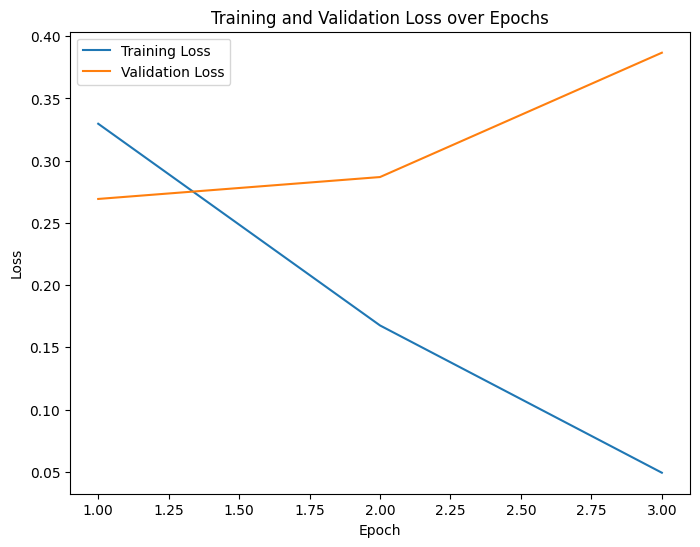

In [11]:
# Plot the training and validation losses
import matplotlib.pyplot as plt

# Defining the range of the epochs
epochs_range = range(1, epochs + 1)

# Creating the figure
plt.figure(figsize=(8, 6))

# Plot training and validation losses
plt.plot(epochs_range, training_loss_values, label='Training Loss')
plt.plot(epochs_range, validation_loss_values, label='Validation Loss')

# Labels and the title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Legend
plt.legend()

# Displaying the plot
plt.show()

In [12]:
## Save the fine-tuned model and tokenizer
model.save_pretrained('./fine_tuned_distilbert')
tokenizer.save_pretrained('./fine_tuned_distilbert')


('./fine_tuned_distilbert/tokenizer_config.json',
 './fine_tuned_distilbert/special_tokens_map.json',
 './fine_tuned_distilbert/vocab.txt',
 './fine_tuned_distilbert/added_tokens.json',
 './fine_tuned_distilbert/tokenizer.json')

# Base Model Comparison

*The* following will evaluate the performance of the base model and a fine-tuned model for the binary classification task utilizing DistilBERT. The function evaluate_model will evaluate the model by generating predictions and collecting the true labels through the utilization of a test DataLoader. Additionally, it uses torch.no_grad() to disable gradient calculations to improve the efficiency during the evaluation. The non-fine-tuned base model, DistilBertForSequenceClassification, is loaded from the Hugging Face transformers libray. To which then the fine-tuned DistilBERT model, which is locally stored, is loaded for its evaluation. The Dataloader is then created for the val_dataset with a sequential strategy that has a batch size of 64. The model evaluation is done with the generation of predictions and true labels for both the base model and fine-tuned model by using the "evaluate_model" function. The results are then summarized with the utilization of the classification_report from the sklearn library for the following metrics: precision (how often a machine learning model correctly predicts the positive class), recall (how well a model can identify positive instances in a data set), and F1-score (the measure of predictive performance). Confusion matrices are also visualized with "seaborn" for each of the models with a red heatmap for the base model and a green heatmap for the fine-tuned-model. I figured that the heatmap would provide the best visualization of the models. Finally, the performance is compared as there is differences in the accuracy and weighted F1-scores between the base and fine-tuned models. As seen from the scores, the fine-tuned model was much more accurate, especially with its positive recall score.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Base Model...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


Evaluating Fine-Tuned Model...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


Base Model Performance:
              precision    recall  f1-score   support

    Negative       0.50      0.99      0.67      5000
    Positive       0.61      0.02      0.04      5000

    accuracy                           0.50     10000
   macro avg       0.56      0.50      0.35     10000
weighted avg       0.56      0.50      0.35     10000


Fine-Tuned Model Performance:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



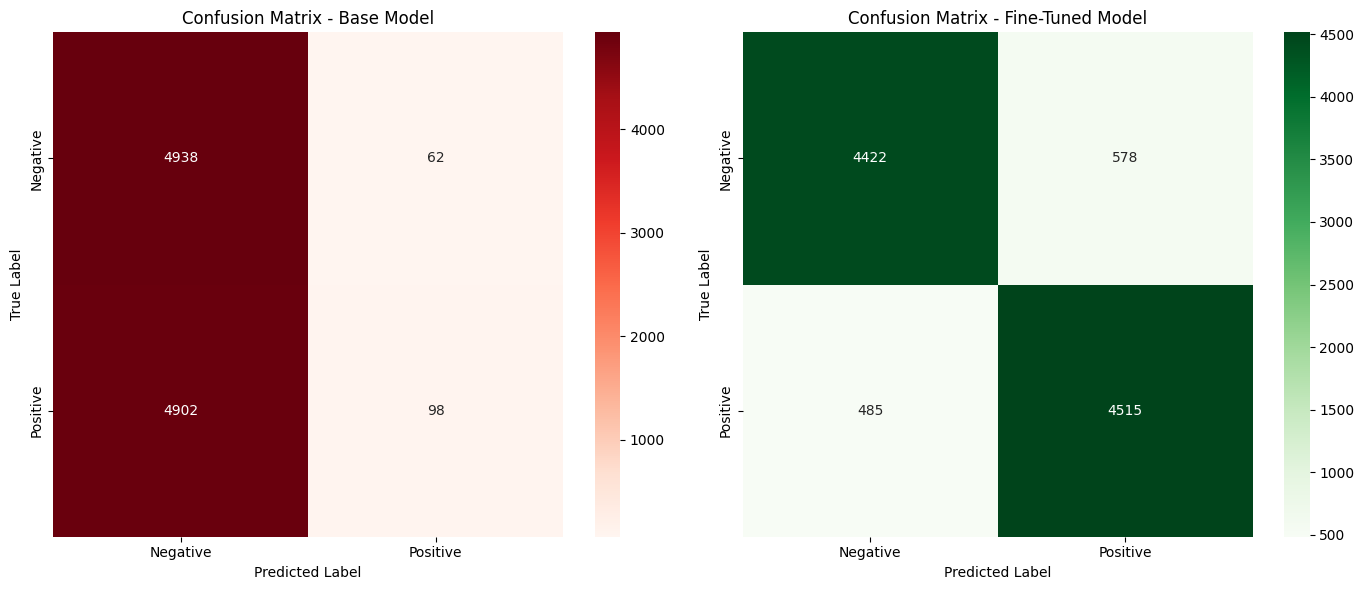


Performance Comparison (Fine-Tuned Model vs. Base Model):
Accuracy Improvement: 0.3901
Weighted F1-Score Improvement: 0.5419


In [13]:
# Importing the necessary libraries
from transformers import DistilBertForSequenceClassification
import torch
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Define the evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()  # Evaluation mode
    predictions = [] # Store the predictions
    true_labels = [] # Store true label

    with torch.no_grad(): # Disable the gradient calculations
        for batch in tqdm(data_loader, desc='Evaluating'): # Looping through the data loader
            input_ids = batch['input_ids'].to(device) # Input IDS move to device
            attention_mask = batch['attention_mask'].to(device) # Move the labels to the device
            labels = batch['labels'].to(device)

            # Forward pass through the model
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits # Get logits from the output of the model

            preds = torch.argmax(logits, dim=-1) # Logits converted to predicted labels
            predictions.extend(preds.cpu().numpy()) # Predictions added to the list
            true_labels.extend(labels.cpu().numpy()) # True labels added to the list

    return predictions, true_labels # returns predictions and the true labels

# Load the base model (non-fine-tuned)
base_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') # Loading DistilBERT base
base_model.to(device) # Model moved to device

# Load the fine-tuned model
fine_tuned_model = DistilBertForSequenceClassification.from_pretrained('./fine_tuned_distilbert') # Loading fine-tuned model
fine_tuned_model.to(device) # Model moved to device

# Create DataLoader for the test data if it is not already created
from torch.utils.data import DataLoader, SequentialSampler

# Create DataLoader for the test dataset
test_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=64)

# Predictions from both models
print("Evaluating Base Model...")
base_preds, true_labels = evaluate_model(base_model, test_loader, device) # Evaluate the base model

print("\nEvaluating Fine-Tuned Model...")
fine_tuned_preds, _ = evaluate_model(fine_tuned_model, test_loader, device) # Evaluate the fine tuned model

# Print classification reports
print("\nBase Model Performance:")
print(classification_report(true_labels, base_preds, target_names=['Negative', 'Positive'])) # Base metrics

print("\nFine-Tuned Model Performance:")
print(classification_report(true_labels, fine_tuned_preds, target_names=['Negative', 'Positive'])) # Fine-tuned metrics

# Confusion matrices plot
# Setting the figure size
plt.figure(figsize=(14, 6))

# Confusion matrix for the base
plt.subplot(1, 2, 1) # First subplot
cm_base = confusion_matrix(true_labels, base_preds)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Negative', 'Positive'], # X-axis
            yticklabels=['Negative', 'Positive']) # Y-axis
plt.title('Confusion Matrix - Base Model') # Title
plt.xlabel('Predicted Label') # X-axis label
plt.ylabel('True Label') # Y-axis label

# Confusion matrix for the fine-tuned
plt.subplot(1, 2, 2) # Second subplot
cm_ft = confusion_matrix(true_labels, fine_tuned_preds)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Fine-Tuned Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adjusting and displaying the plots
plt.tight_layout()
plt.show()

# Calculate and display the performance differences
print("\nPerformance Comparison (Fine-Tuned Model vs. Base Model):")
# Classification reports for the detailed metrics
base_report = classification_report(true_labels, base_preds, output_dict=True, zero_division=0)
fine_tuned_report = classification_report(true_labels, fine_tuned_preds, output_dict=True, zero_division=0)

# Comparison of accuracy
accuracy_improvement = fine_tuned_report['accuracy'] - base_report['accuracy'] # Accuracy improvement
f1_improvement = fine_tuned_report['weighted avg']['f1-score'] - base_report['weighted avg']['f1-score'] # F1-score improvement

# Print the preformance improvements
print(f"Accuracy Improvement: {accuracy_improvement:.4f}")
print(f"Weighted F1-Score Improvement: {f1_improvement:.4f}")

# GPT-2 Comparison

The following is the comparsion between the previous two models (DistilBERT base and the fine-tuned) along with the GPT-2 base. The script tokenizes the val_texts (test data) using the appropriate tokenizer (DistilBERT or GPT-2) and then creates a custom dataset class called GPT2Dataset for GPT-2 to pair the tokenized inputs with their corresponding labels. The script uses the evaluate_model function (similar to the last) to generate the predictions for the models on the test dataset to which it then collects the true labels and predicted labels for each of the models. A classification report for each model is generated through the utilization of sklearn.metrics.classification_report where it provides the following: precision, recall, F1-score, and accuracy. Visualization of the confusion matrices for all three of the models is made through the use of seaborn.

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluating GPT-2 Base Model...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


GPT-2 Base Model Performance:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67      5000
    Positive       0.67      0.00      0.00      5000

    accuracy                           0.50     10000
   macro avg       0.58      0.50      0.33     10000
weighted avg       0.58      0.50      0.33     10000



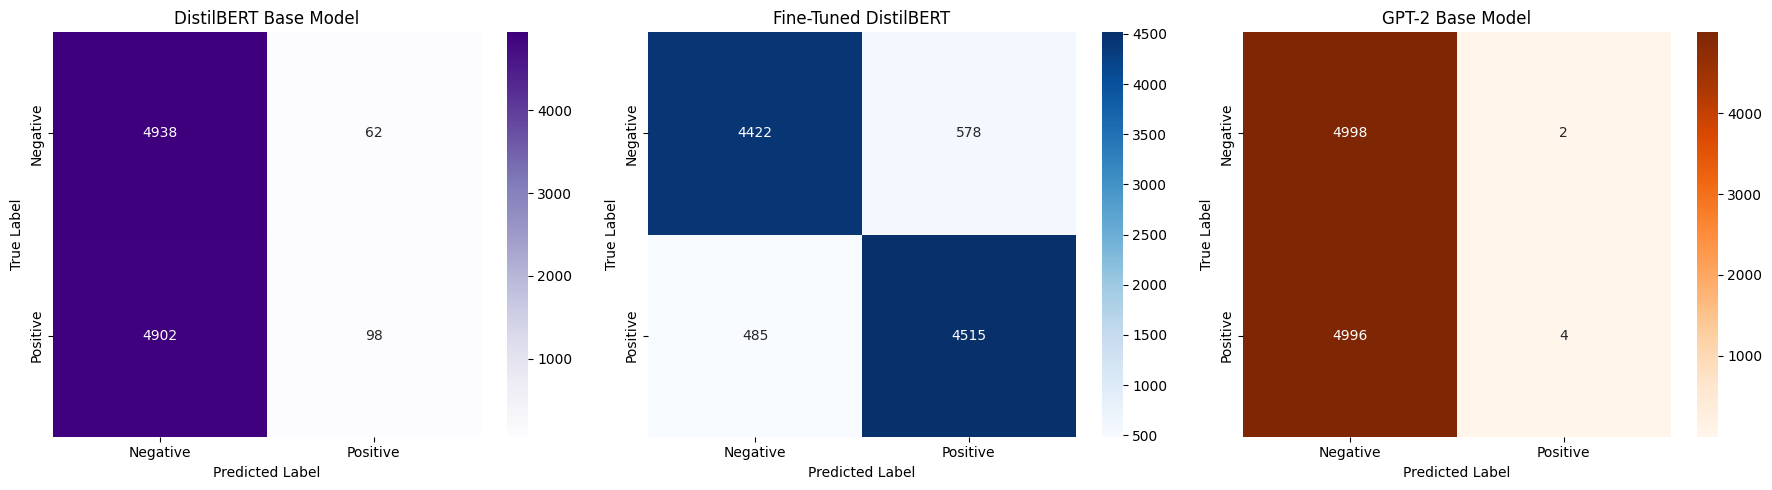


Model Comparison:
DistilBERT Base Accuracy: 0.5036
Fine-Tuned DistilBERT Accuracy: 0.8937
GPT-2 Base Accuracy: 0.5002

DistilBERT Base Weighted F1: 0.3517
Fine-Tuned DistilBERT Weighted F1: 0.8937
GPT-2 Base Weighted F1: 0.3341


In [14]:
# Import necessary libraries
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
import torch
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and load the GPT-2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Add padding token to GPT-2 tokenizer and set the padding toekn to the end of sequence token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Initialize GPT-2 model for sequence classification with 2 labels
gpt2_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2) # Load GPT-2 for classification
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id # Configuring the padding token ID
gpt2_model.to(device) # Moving the model to the device (GPU/CPU)

# Tokenize test data for GPT-2
gpt2_test_encodings = gpt2_tokenizer(
    list(val_texts), # Validation texts
    truncation=True, # Truncate texts that exceed the max length
    padding=True, # Padding to shorter texts
    max_length=128, # Maximum token length
    return_tensors='pt' # Return the Pytorch tensors
)

# Create GPT-2 test dataset
class GPT2Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings # Encoded input data
        self.labels = labels.reset_index(drop=True) # Reset index for the labels

    def __len__(self):
        return len(self.labels) # Length of dataset

    def __getitem__(self, idx):
        # Get the item at a specific index
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long) # adding labels as tensors
        return item

gpt2_test_dataset = GPT2Dataset(gpt2_test_encodings, val_labels) # Create the dataset object

# Create DataLoader for GPT-2 test data
gpt2_test_loader = torch.utils.data.DataLoader(gpt2_test_dataset, batch_size=64, sampler=torch.utils.data.SequentialSampler(gpt2_test_dataset)) #

# Evaluate GPT-2 base model
print("\nEvaluating GPT-2 Base Model...")
gpt2_preds, _ = evaluate_model(gpt2_model, gpt2_test_loader, device) # Predictions for GPT-2

# Print GPT-2 performance
print("\nGPT-2 Base Model Performance:")
print(classification_report(true_labels, gpt2_preds, target_names=['Negative', 'Positive'])) # Classification metrics

# Plot confusion matrices for all three models with different visual styles
plt.figure(figsize=(18, 5)) # Setting the figure size

# Confusion matrix for DistilBERT base model
plt.subplot(1, 3, 1) # Subplot 1
sns.heatmap(confusion_matrix(true_labels, base_preds),
            annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('DistilBERT Base Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Confusion matrix for fine-tuned DistilBERT
plt.subplot(1, 3, 2) # Subplot 2
sns.heatmap(confusion_matrix(true_labels, fine_tuned_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Fine-Tuned DistilBERT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Confusion matrix for GPT-2 base model
plt.subplot(1, 3, 3) # Subplot 3
sns.heatmap(confusion_matrix(true_labels, gpt2_preds),
            annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('GPT-2 Base Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display and adjust the plot
plt.tight_layout()
plt.show()

# Compare all three models
print("\nModel Comparison:")
gpt2_report = classification_report(true_labels, gpt2_preds, output_dict=True, zero_division=0)

# Print the model performance comparison
print(f"DistilBERT Base Accuracy: {base_report['accuracy']:.4f}")
print(f"Fine-Tuned DistilBERT Accuracy: {fine_tuned_report['accuracy']:.4f}")
print(f"GPT-2 Base Accuracy: {gpt2_report['accuracy']:.4f}")

print(f"\nDistilBERT Base Weighted F1: {base_report['weighted avg']['f1-score']:.4f}")
print(f"Fine-Tuned DistilBERT Weighted F1: {fine_tuned_report['weighted avg']['f1-score']:.4f}")
print(f"GPT-2 Base Weighted F1: {gpt2_report['weighted avg']['f1-score']:.4f}")

# Classical ML Comparison

The following script trians and evaluates Logistic Regression model by utilizing TF-IDF features and also compares its performance to the previous three other models. The TF-IDF Vectorizer is created to transform the text data into a sparse matrix of features (10,000 max features, lowercase text, and removal of stop word). The model is trained on the data X_train_tfidf and the corresponding labels y_train. Along with the training time being recorded, the scripts predictions are made on the test data X_test_tfidf and the performance metrics are computed by utilizing the classification_report from the sklearn library. Confusion matrices of all four models are once again plotted with the use of seaborn in which they compare the Accuracy and weighted F1-scores of the models.

Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



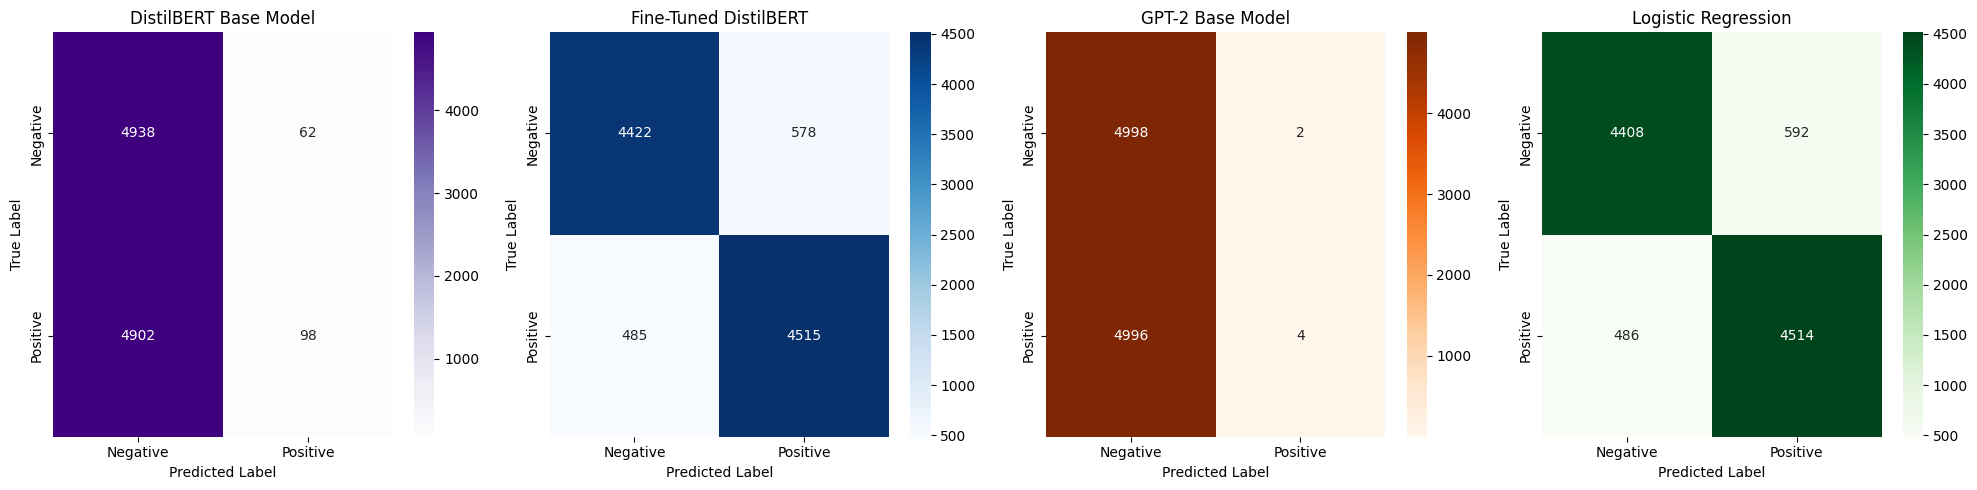


Model Comparison Summary:
Model                    Accuracy  Weighted F1-Score
DistilBERT Base          0.5036    0.3517
Fine-Tuned DistilBERT    0.8937    0.8937
GPT-2 Base               0.5002    0.3341
Logistic Regression      0.8922    0.8922

Logistic Regression Training Time: 6.67 seconds


In [15]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Start timing the training process
start_time = time.time()

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(val_texts)

# Convert labels to numeric format if necessary
# Assuming train_labels and val_labels are already numeric (0 and 1)
y_train = train_labels.reset_index(drop=True)
y_test = val_labels.reset_index(drop=True)

# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Calculate training time
training_time = time.time() - start_time

# Make predictions on the test set
lr_preds = lr_model.predict(X_test_tfidf)

# Print performance metrics
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_preds, target_names=['Negative', 'Positive']))

# Plot confusion matrices for all models with distinct styles
plt.figure(figsize=(20, 5))

# DistilBERT Base Model
plt.subplot(1, 4, 1) # Subplot 1
sns.heatmap(confusion_matrix(true_labels, base_preds),
            annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('DistilBERT Base Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fine-Tuned DistilBERT
plt.subplot(1, 4, 2) # Subplot 2
sns.heatmap(confusion_matrix(true_labels, fine_tuned_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Fine-Tuned DistilBERT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# GPT-2 Base Model
plt.subplot(1, 4, 3) # Subplot 3
sns.heatmap(confusion_matrix(true_labels, gpt2_preds),
            annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('GPT-2 Base Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Logistic Regression Model
plt.subplot(1, 4, 4) # Subplot 4
sns.heatmap(confusion_matrix(y_test, lr_preds),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Get Logistic Regression metrics
lr_report = classification_report(y_test, lr_preds, output_dict=True, zero_division=0)

# Compare all models
print("\nModel Comparison Summary:")
print(f"{'Model':<25}{'Accuracy':<10}{'Weighted F1-Score'}")
print(f"{'DistilBERT Base':<25}{base_report['accuracy']:.4f}    {base_report['weighted avg']['f1-score']:.4f}")
print(f"{'Fine-Tuned DistilBERT':<25}{fine_tuned_report['accuracy']:.4f}    {fine_tuned_report['weighted avg']['f1-score']:.4f}")
print(f"{'GPT-2 Base':<25}{gpt2_report['accuracy']:.4f}    {gpt2_report['weighted avg']['f1-score']:.4f}")
print(f"{'Logistic Regression':<25}{lr_report['accuracy']:.4f}    {lr_report['weighted avg']['f1-score']:.4f}")

print(f"\nLogistic Regression Training Time: {training_time:.2f} seconds")